## Import Libraries

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
import scipy.stats as stats
import pandas as pd
pd.pandas.set_option('display.max_columns',None)

from sklearn.feature_selection import SelectKBest, chi2 ,f_classif
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

## Load the Data

In [8]:
heart = pd.read_csv("../data/heart.csv")
heart.info()
display(heart.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Cleaning the Data

In [9]:
heart_copy=heart.copy()
heart_copy.isnull().sum().sort_values(ascending=False)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Categorical Features Analysis

In [11]:
#Let's find the categorical featuers
cat_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes == object]
cat_features

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

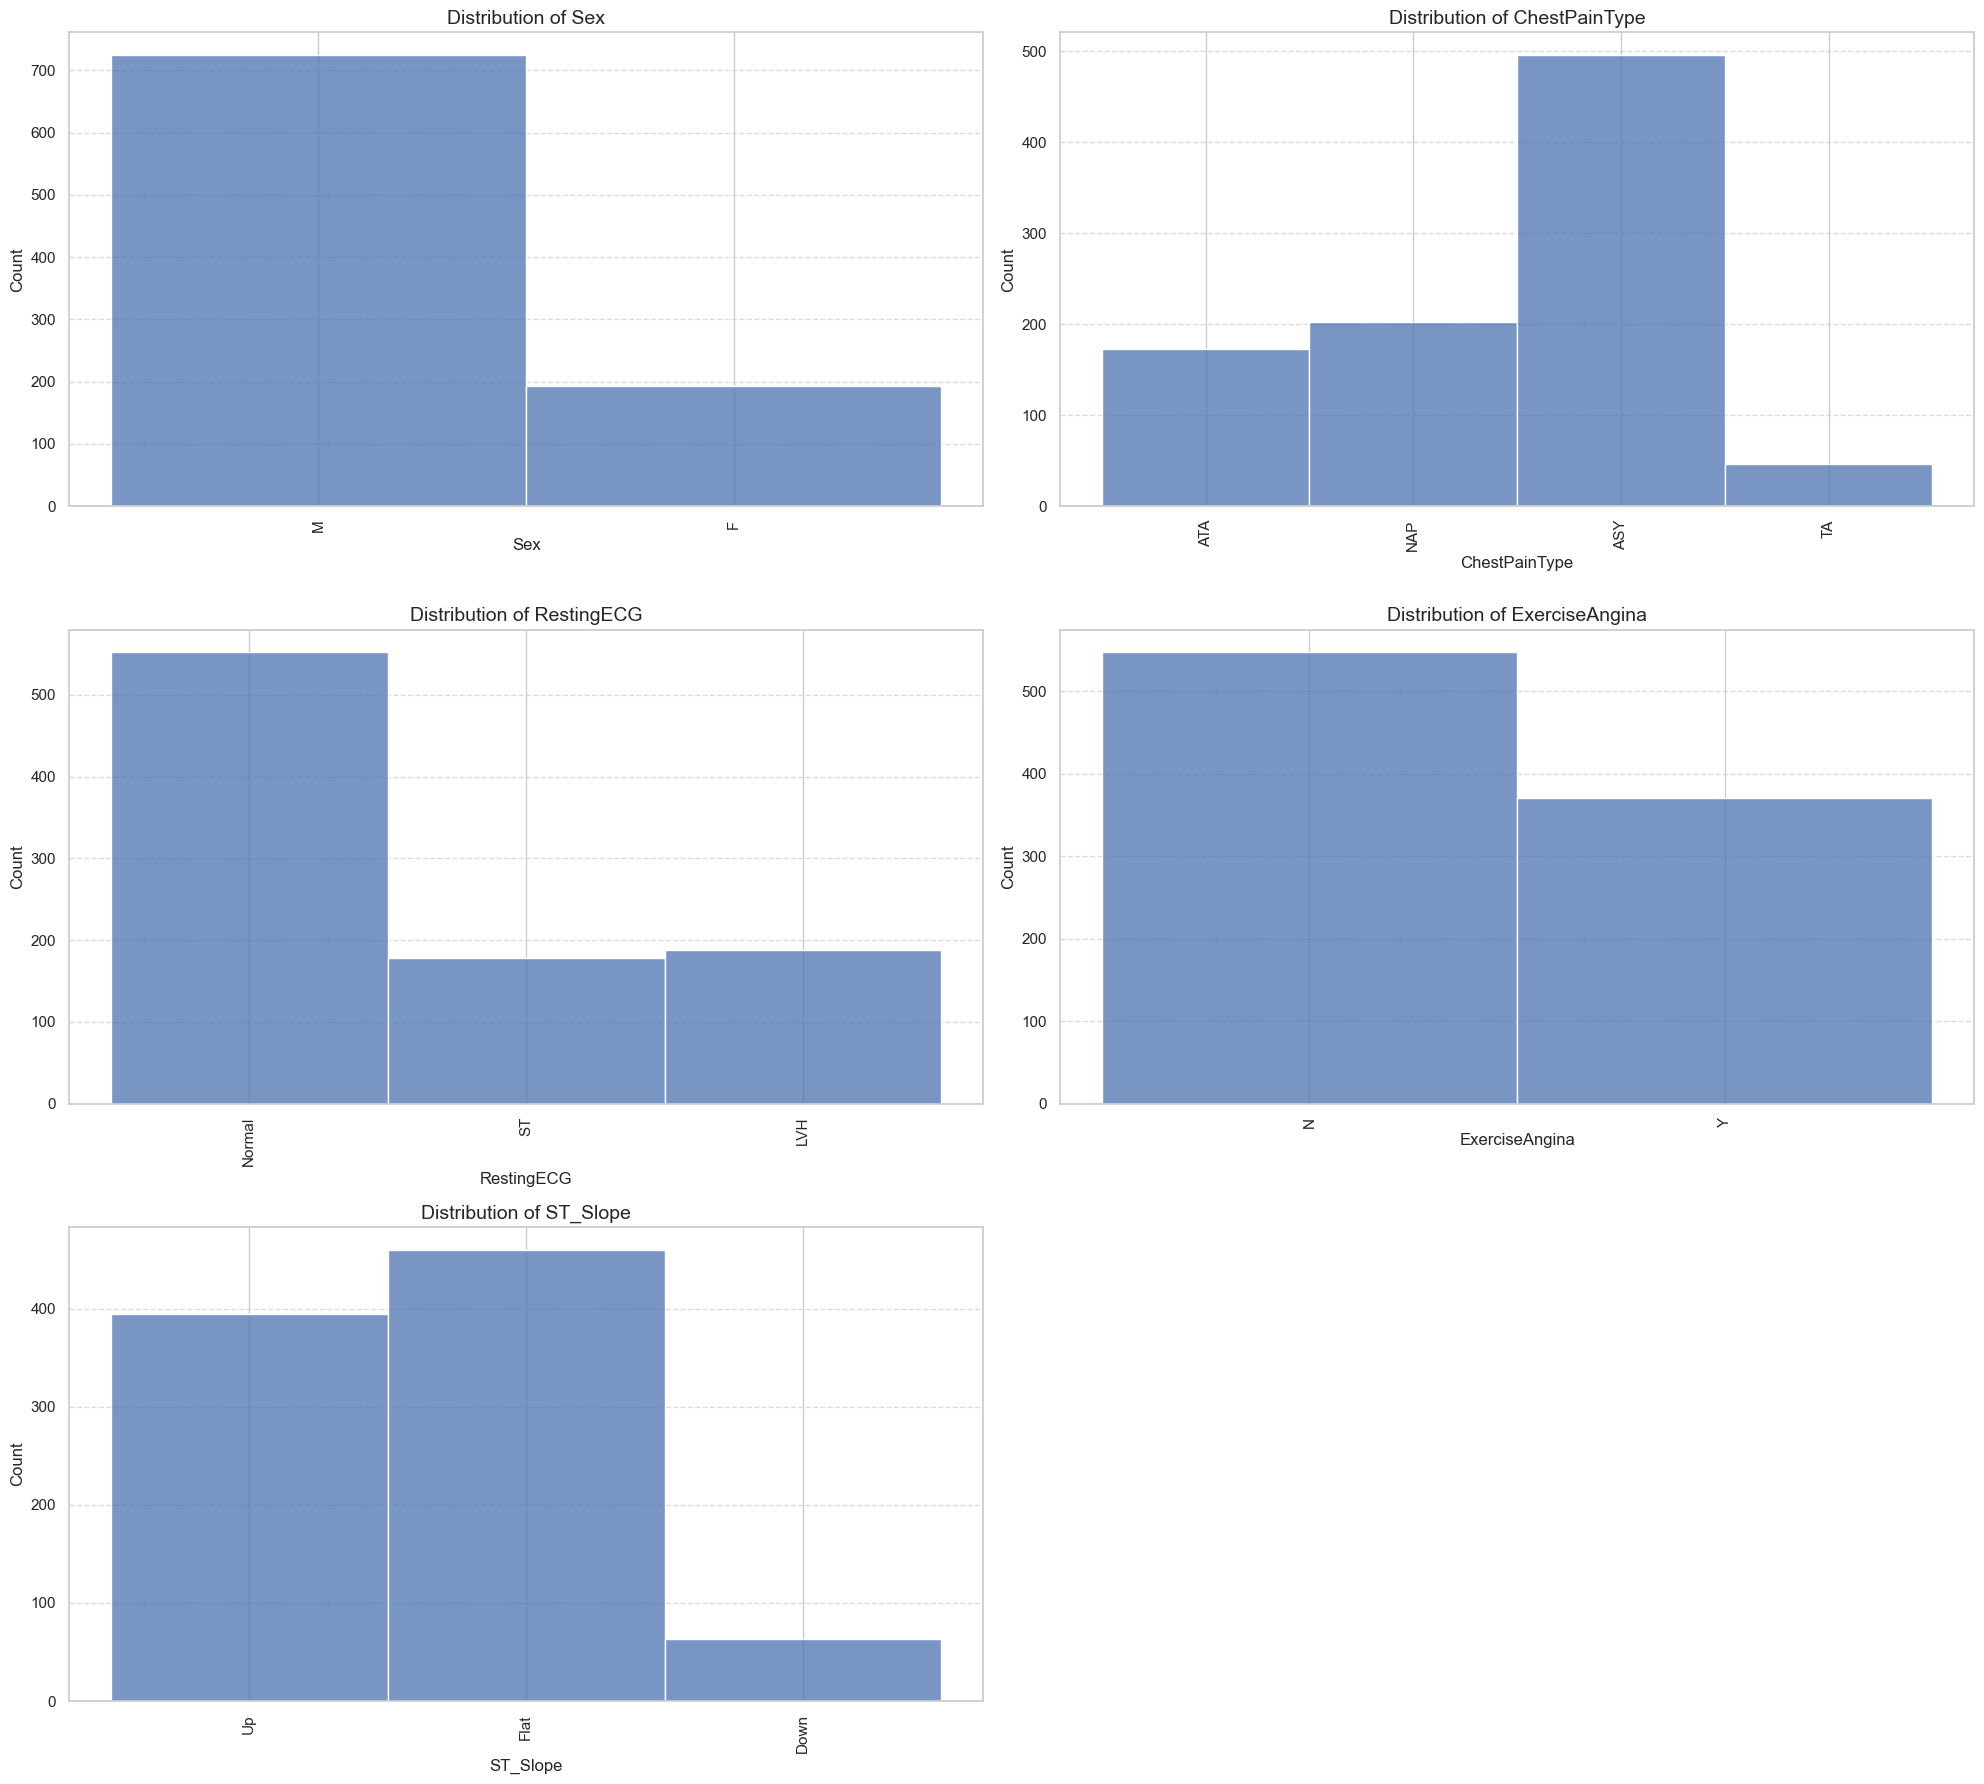

In [12]:
num_columns=2
num_rows=(len(cat_features)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(cat_features):
    ax=axes[i]
    sns.histplot(data=heart_copy,x=col,ax=ax)
    
    ax.set_title(f'Distribution of {col}',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### Heart Disease Ratio Comparison Across Categorical Features

- The distribution of **males** is significantly higher than **females** in the dataset.
- The most frequent **Chest Pain Type** among all individuals is **ASY** (asymptomatic), accounting for nearly half of the dataset.
- More than half of the **Resting ECG** measurements are classified as **Normal**.
- The majority of individuals exhibit a **Flat ST Slope** or **Upward ST Slope**, in contrast to the **Downward ST Slope**, which is less common.

Bivariate Analysis for Categorical Data:

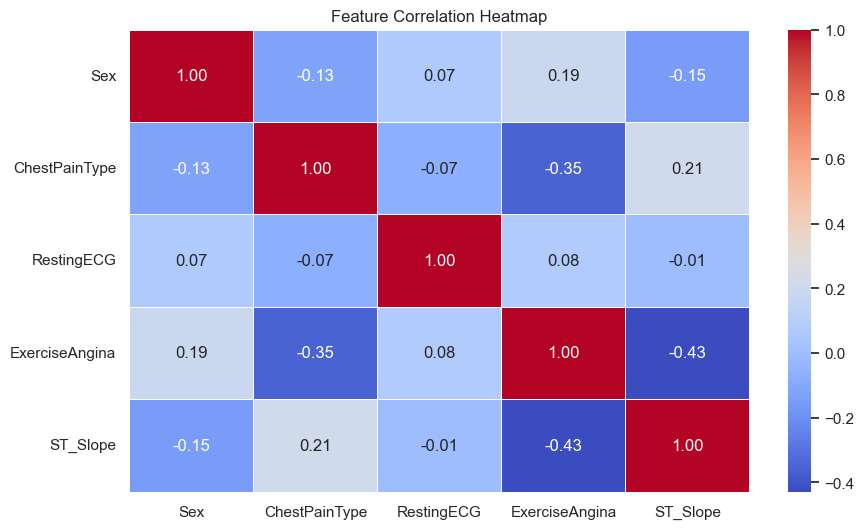

In [13]:
# For corr_matrix we need our categories to be encoded

encoder_ordinal=OrdinalEncoder()

df_new=pd.DataFrame(encoder_ordinal.fit_transform(heart_copy[cat_features]),columns=encoder_ordinal.get_feature_names_out(),index=heart_copy.index)

corr_matrix = df_new.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

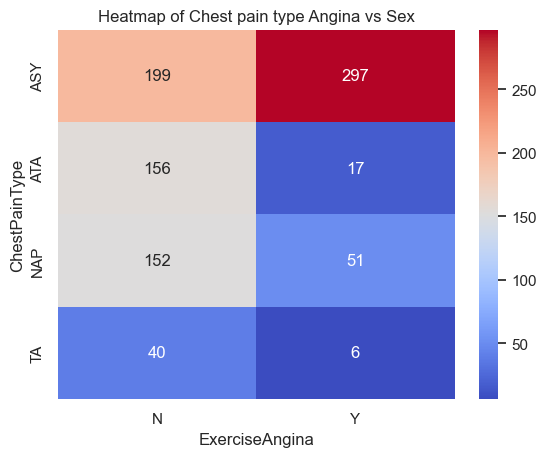

In [14]:
crosstab = pd.crosstab(heart_copy["ChestPainType"], heart_copy["ExerciseAngina"])
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Chest pain type Angina vs Sex")
plt.show()

- The **majority of individuals with ExerciseAngina** experience **ASY (Asymptomatic) Chest Pain Type**.
- This trend suggests that those who develop **exercise-induced angina** often do not exhibit traditional chest pain symptoms.
- The absence of typical chest pain in high-risk individuals may lead to **delayed diagnosis** of cardiovascular issues.
- This pattern could indicate that **silent ischemia** is more prevalent among individuals experiencing angina triggered by physical exertion.

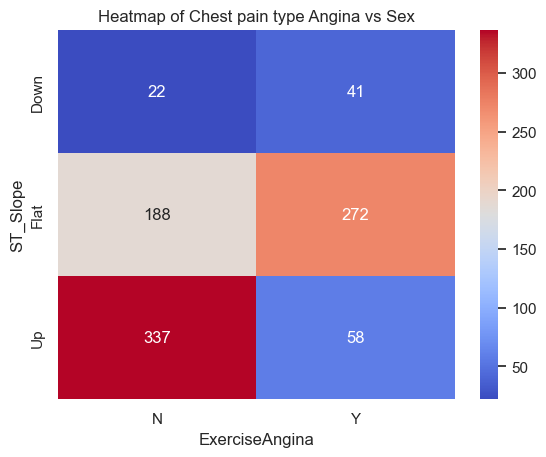

In [15]:
crosstab = pd.crosstab(heart_copy["ST_Slope"], heart_copy["ExerciseAngina"])
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Chest pain type Angina vs Sex")
plt.show()

- Individuals with a **flat ST slope** are more likely to experience **exercise-induced angina**, suggesting a potential link between heart stress and ST segment flattening.
- On the other hand, those with an **upward ST slope** tend to **not experience exercise-induced angina**, which may indicate better cardiovascular adaptability and response to physical exertion.
- This pattern suggests that the **shape of the ST segment during a stress test could be an important factor in diagnosing heart conditions**.

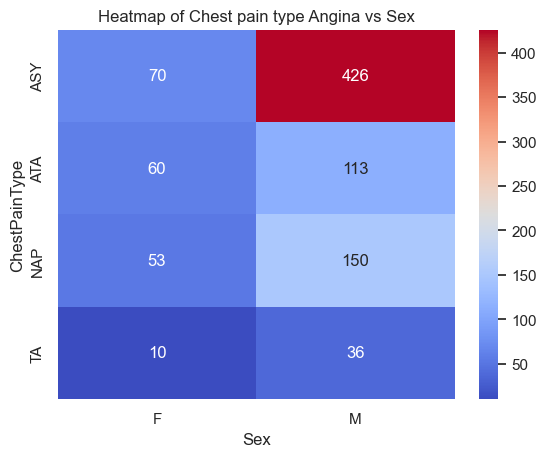

In [16]:
crosstab = pd.crosstab(heart_copy["ChestPainType"], heart_copy["Sex"])
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Chest pain type Angina vs Sex")
plt.show()

- The majority of **male individuals** in the dataset experience **asymptomatic (ASY) chest pain**.
- This trend suggests that **men may be more prone to silent cardiac issues**, where heart disease develops **without noticeable symptoms**.
- Since asymptomatic conditions are harder to detect, this could lead to **delayed diagnosis and treatment**, increasing the risk of severe cardiovascular events.
- The absence of typical chest pain symptoms may indicate that **other diagnostic markers, such as exercise response or ECG patterns, should be examined more closely for men**.

Comparing categorical features with target:

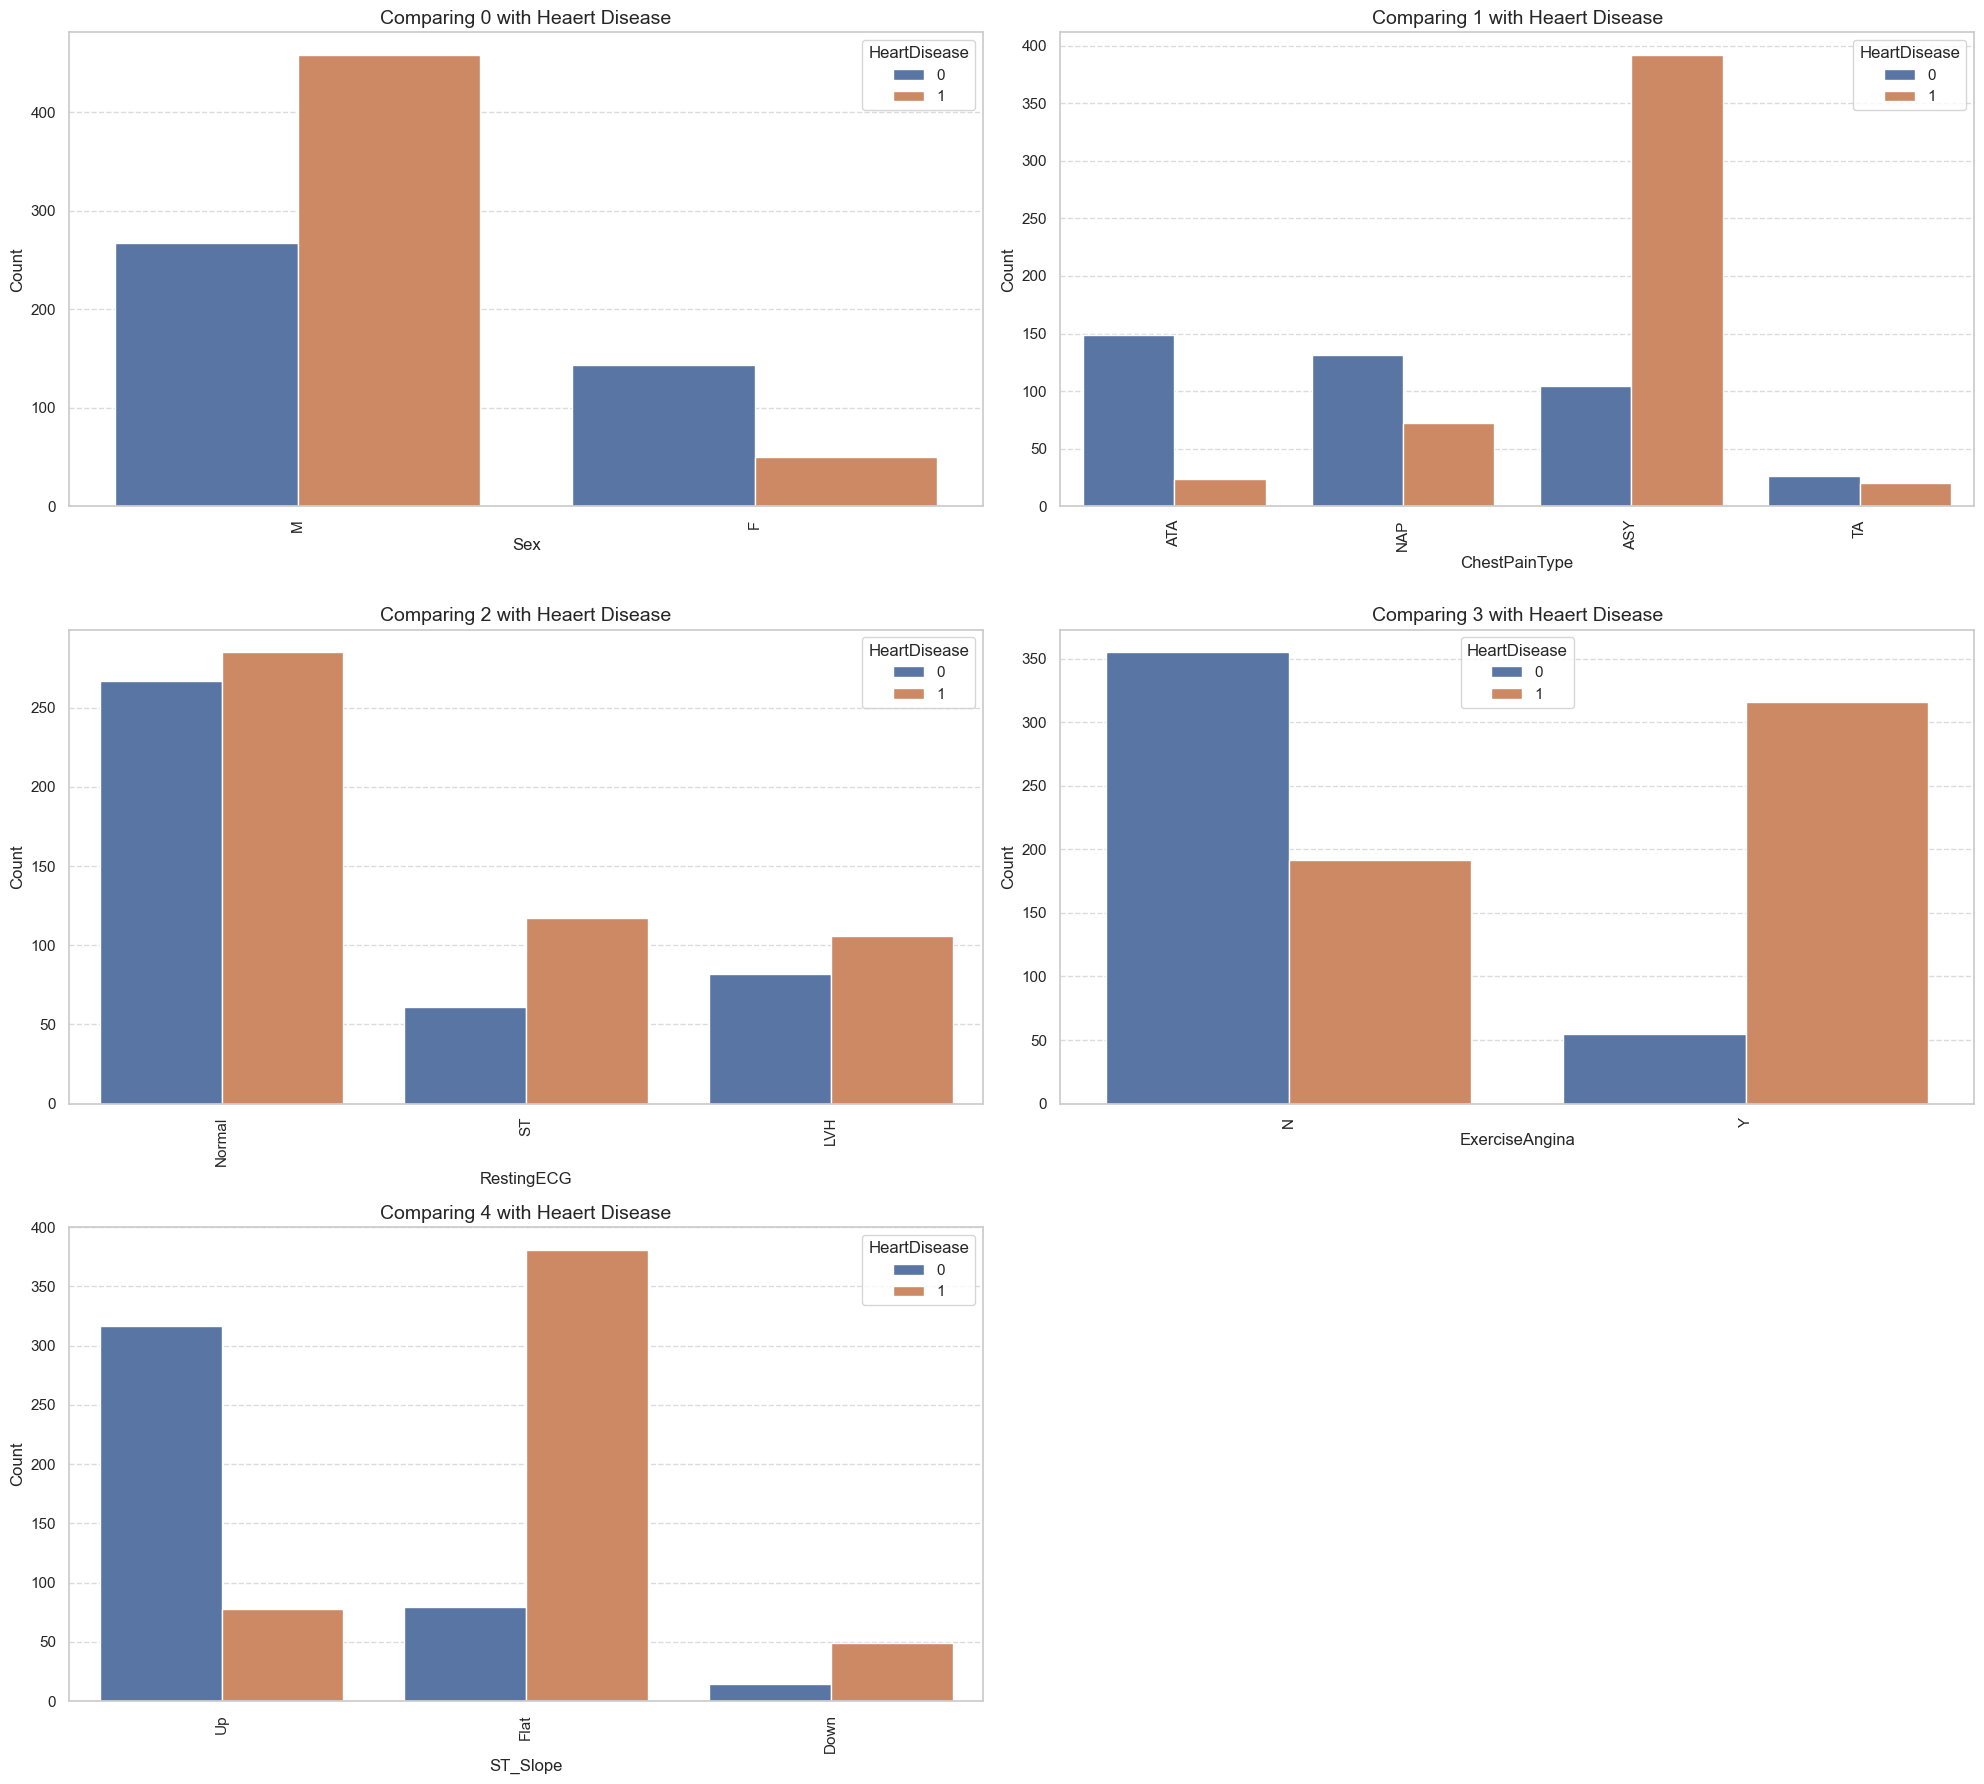

In [17]:
cat_df=pd.concat([heart_copy[cat_features],heart_copy['HeartDisease']],axis=1)

num_columns=2
num_rows=(len(cat_df.columns)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(cat_df.drop(columns=['HeartDisease'])):
    ax=axes[i]
    ax=sns.countplot(ax=ax,data=cat_df,x=col,hue='HeartDisease')

    
    ax.set_title(f'Comparing {i} with Heaert Disease',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
        
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### Gender-Based Insights
- The occurrence of heart disease is notably higher in **males (63.17%)** compared to **females (25.90%)**, suggesting a potential gender-related risk factor.

### Chest Pain Type Analysis
- The most commonly associated **Chest Pain Type** among individuals with heart disease is **ASY (Asymptomatic) at 79.03%**, indicating that many affected individuals might not experience noticeable symptoms.
- **TA (Typical Angina) accounts for 43.47%**, followed by **NAP (Non-Anginal Pain) at 35.46%** and **ATA (Atypical Angina) at 13.87%**, suggesting varying pain symptoms among affected individuals.

### Resting ECG Correlation
- The majority of individuals with heart disease exhibit **ST (65.73%)**, indicating possible ST-segment elevation abnormalities.
- **LVH (Left Ventricular Hypertrophy) is observed in 56.38%**, a known factor associated with heart disease.
- **Normal ECG readings are present in 51.63%**, highlighting that some affected individuals may not show significant ECG abnormalities.

### Exercise-Induced Angina Impact
- A significant majority of individuals with heart disease experience **Exercise-Induced Angina (85.17%)**, reinforcing the connection between exertion and cardiovascular complications.
- **Non-angina cases account for 19.74%**, showing that some individuals may not exhibit angina symptoms despite having heart disease.

### ST Slope Interpretation
- **Flat ST Slope is predominant (82.82%)**, which is commonly associated with adverse cardiac conditions.
- **Downward ST Slope follows closely (77.77%)**, indicating potential ischemic heart disease risk.
- **Upward ST Slope is the least frequent (19.74%)**, suggesting it may be less indicative of severe cardiac issues.

## Numerical Features Analysis

In [18]:
#First we go for Discrete  numerical features
dis_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes!=object and heart_copy[feature].nunique()<10]
dis_features

['FastingBS', 'HeartDisease']

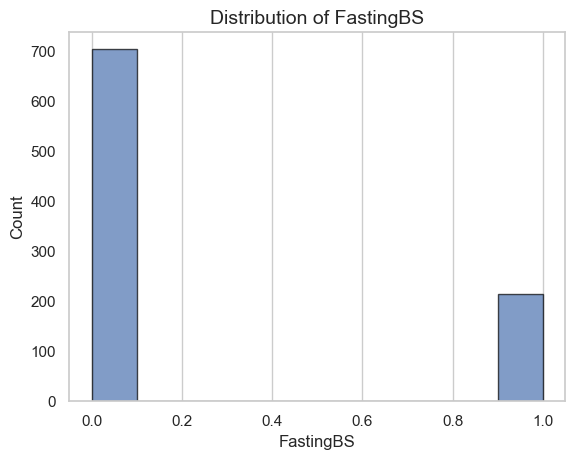

In [19]:
plt.figure()
plt.hist(heart_copy['FastingBS'],edgecolor='black',alpha=0.7)
plt.grid(axis='y')
plt.title('Distribution of FastingBS',fontsize=14)
plt.xlabel('FastingBS',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.show()

### Fasting Blood Sugar Distribution

- The majority of individuals in the dataset have a **Fasting Blood Sugar (FastingBS) value of 0**, accounting for more than **70%** of the data.
- This suggests that most individuals did not have elevated fasting blood sugar levels, which may indicate a lower prevalence of diabetes or prediabetes within the dataset.

TypeError: bar_label() missing 1 required positional argument: 'container'

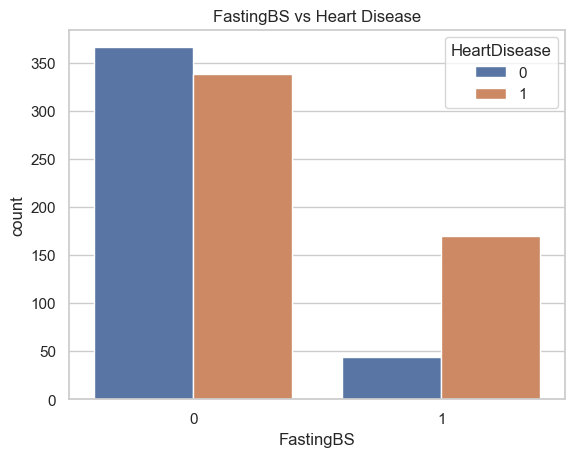

In [21]:
plt.figure()
ax=sns.countplot(data=heart_copy,x='FastingBS',hue='HeartDisease')
plt.title('FastingBS vs Heart Disease')
ax.bar_label()
plt.show()

### Relationship Between Fasting Blood Sugar and Heart Disease

### Observations
- Individuals with **FastingBS = 1** (indicating elevated fasting blood sugar levels) have a significantly higher prevalence of heart disease (**79.43%**).
- In contrast, individuals with **FastingBS = 0** exhibit a lower heart disease prevalence (**48.01%**).
- This suggests a strong correlation between elevated **fasting blood sugar** and the likelihood of heart disease, reinforcing the potential impact of diabetes or glucose metabolism on cardiovascular health.

### Heart Disease Ratio Comparison: Fasting Blood Sugar

### **Fasting Blood Sugar Levels**
- **1 (High Fasting Blood Sugar):** 79.43  
- **0 (Normal Fasting Blood Sugar):** 48.01  

*A higher fasting blood sugar level (≥ 126 mg/dL) is strongly associated with an increased likelihood of heart disease.*


In [22]:
#Know we go for continuous numerical features
conti_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes!=object and feature not in dis_features]
conti_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

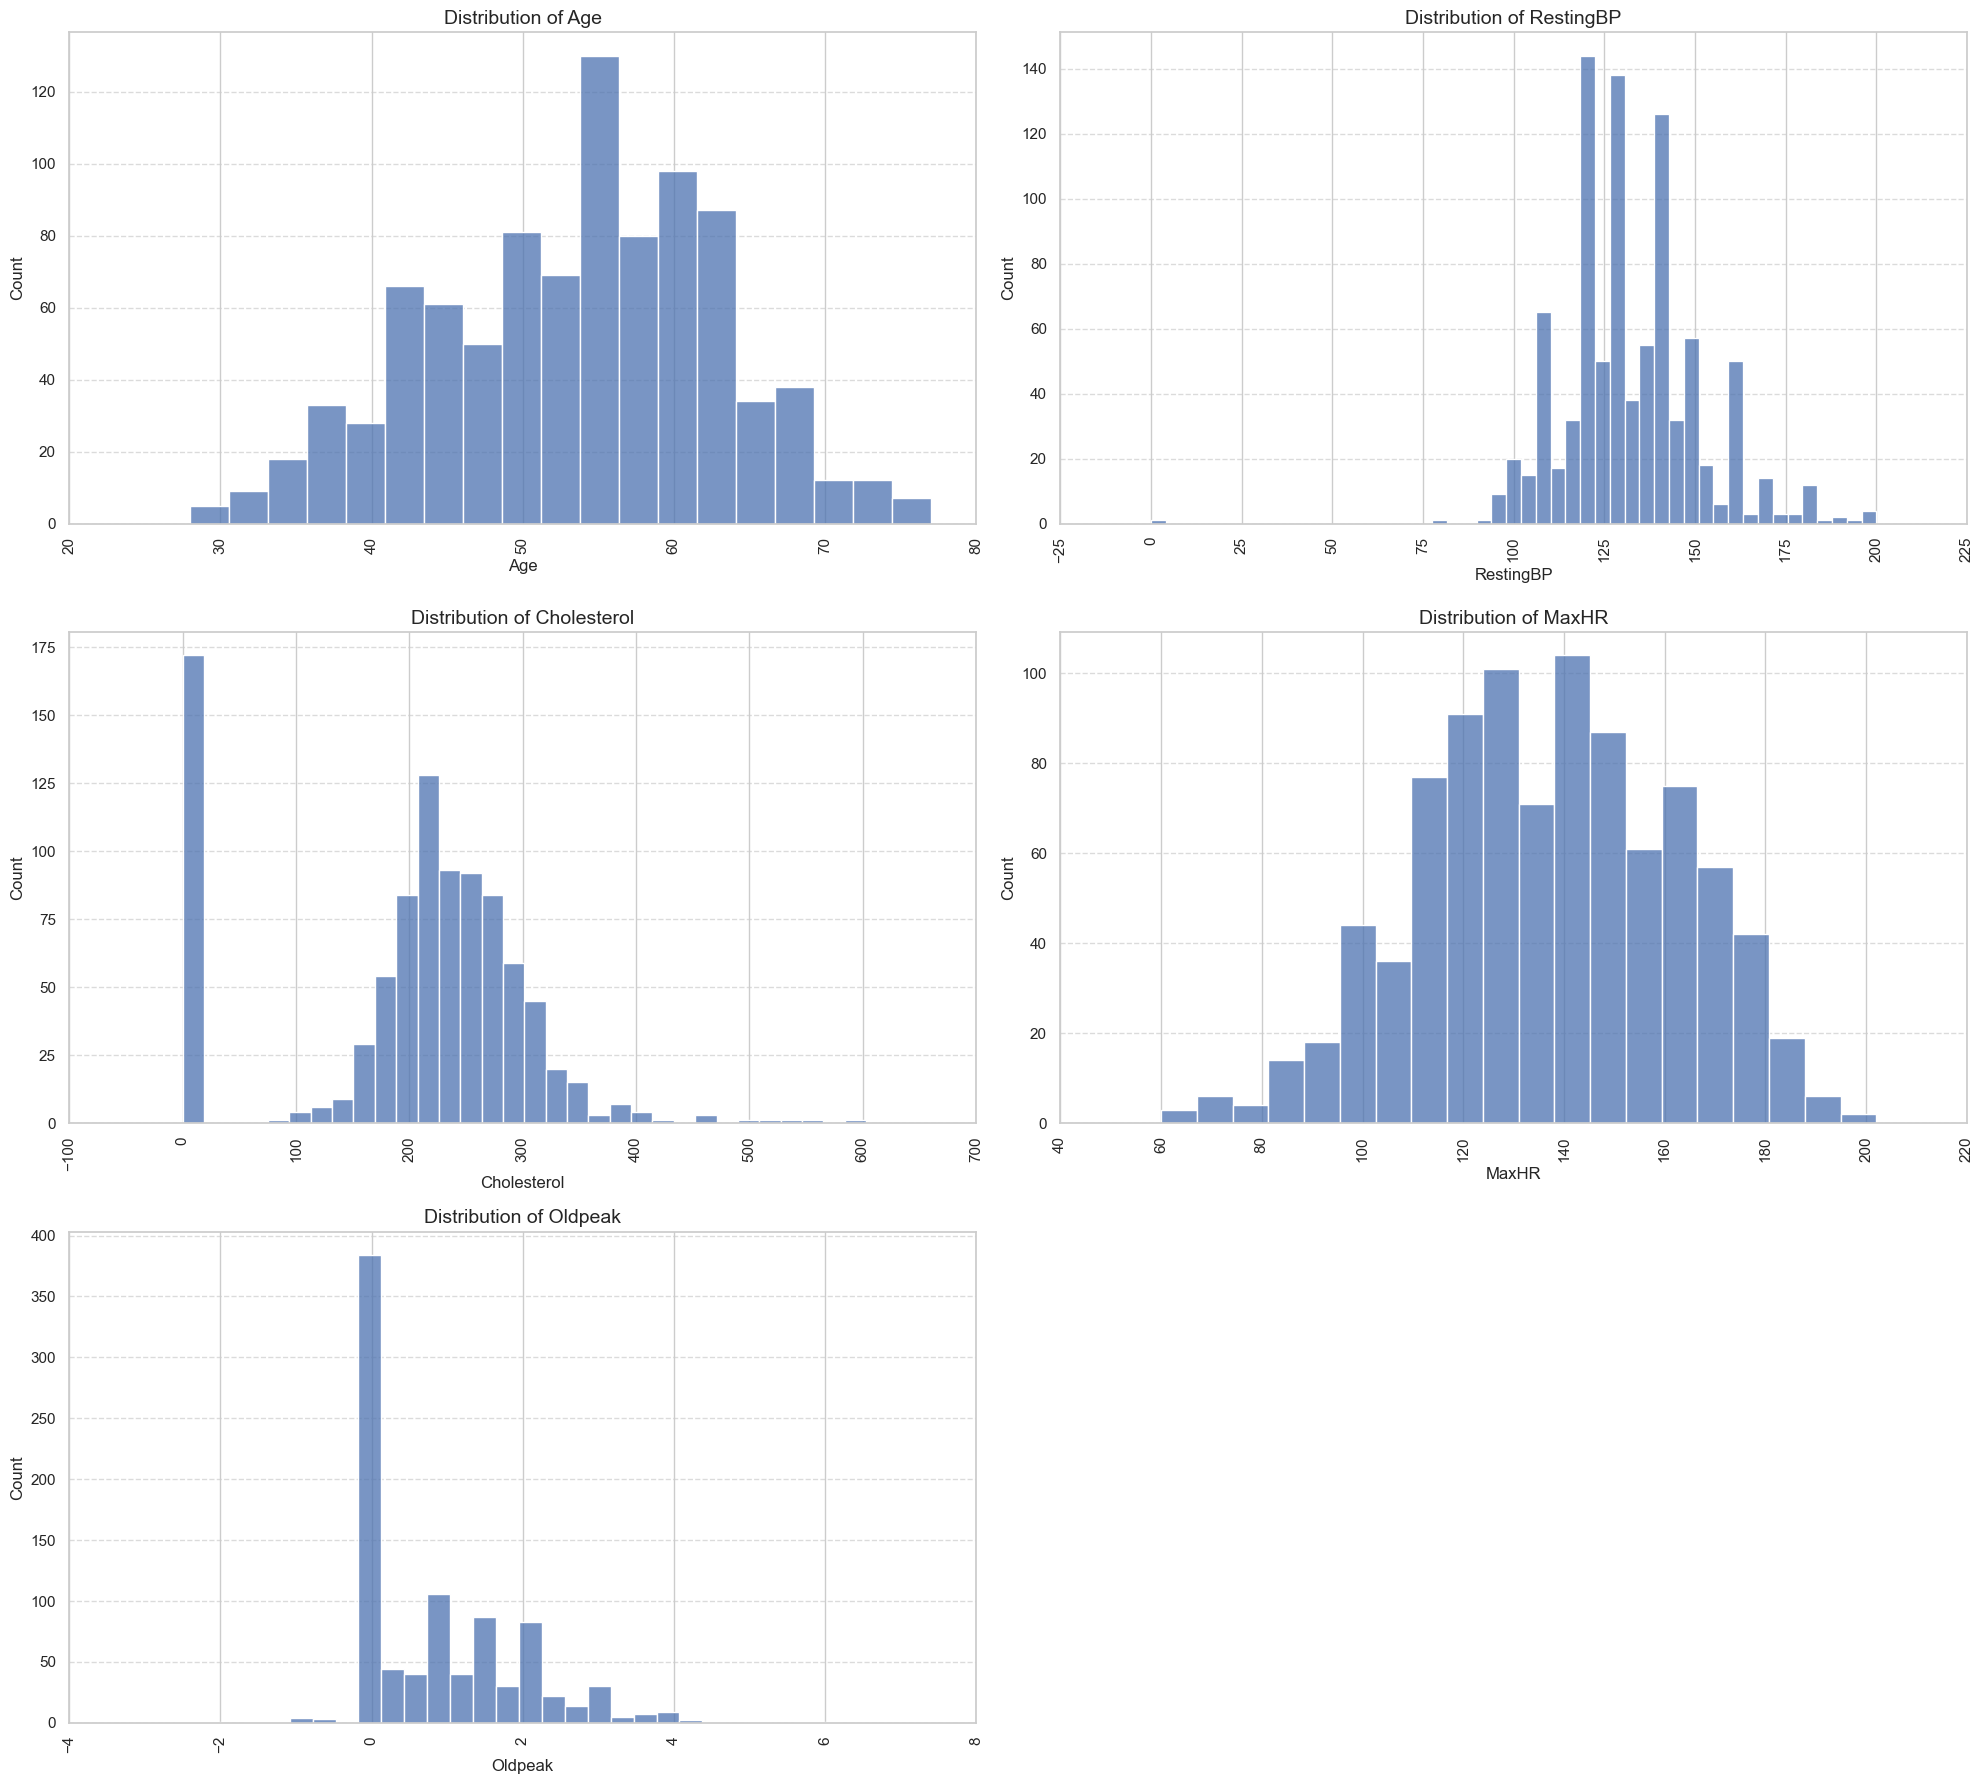

In [23]:
num_columns=2
num_rows=(len(conti_features)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(conti_features):
    ax=axes[i]
    sns.histplot(data=heart_copy,x=col,ax=ax)
    
    ax.set_title(f'Distribution of {col}',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### Data Quality Assessment

### Age
- No invalid values detected for **Age** in the dataset.

### Resting Blood Pressure (RestingBP)
- **Zero values** for **RestingBP** are invalid.
- These values will be replaced with **nulls** to ensure data integrity.

### Cholesterol
- **Zero values** for **Cholesterol** are considered invalid.
- Since a large portion of the dataset contains **zero values**, a separate investigation is conducted to assess potential issues.See the separate analyisis further.

### Oldpeak
- No invalid values detected for **Oldpeak** at this stage of analysis.

In [24]:
# We convert invalid zeros for RestingBP then we drop it.
heart_copy['RestingBP']=heart_copy['RestingBP'].replace(0,np.nan)
heart_copy.dropna(subset=['RestingBP'],inplace=True)

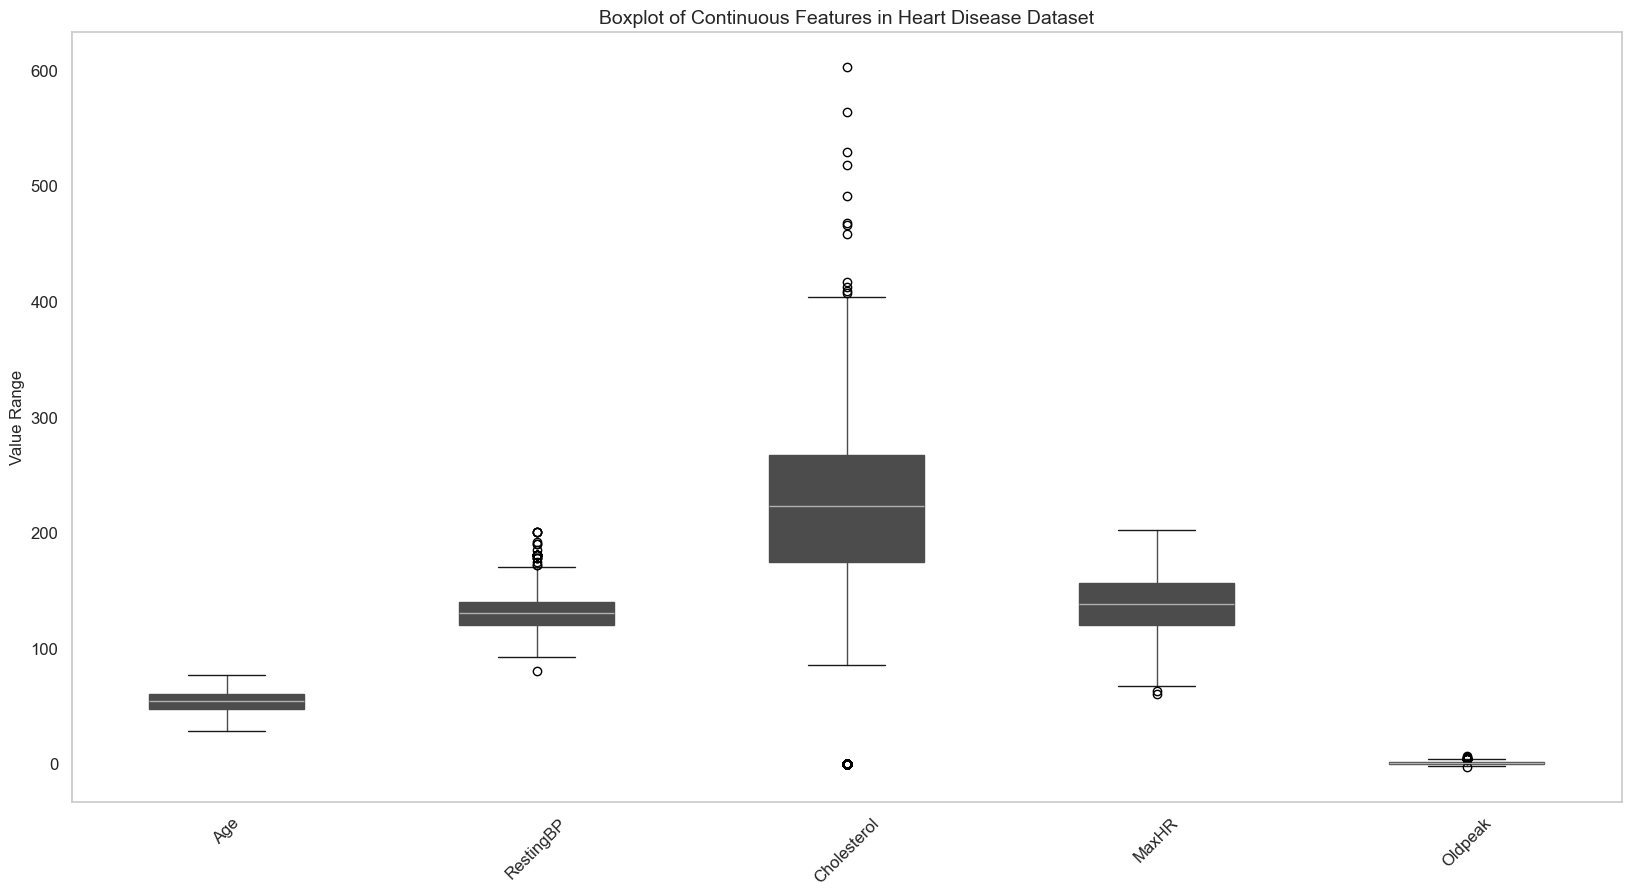

In [25]:

boxplot = heart_copy[conti_features].boxplot(figsize=(20,10), grid=False, fontsize=12, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow']  # Adjust as needed
for patch, color in zip(boxplot.artists, colors):
    patch.set_facecolor(color)

plt.title("Boxplot of Continuous Features in Heart Disease Dataset", fontsize=14)
plt.ylabel("Value Range")
plt.xticks(rotation=45)  
plt.show()

In [26]:
heart_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,917.0,53.509269,9.437636,28.0,47.0,54.0,60.0,77.0
RestingBP,917.0,132.540894,17.999749,80.0,120.0,130.0,140.0,200.0
Cholesterol,917.0,199.016358,109.246330,0.0,174.0,223.0,267.0,603.0
FastingBS,917.0,0.233370,0.423206,0.0,0.0,0.0,0.0,1.0
MaxHR,917.0,136.789531,25.467129,60.0,120.0,138.0,156.0,202.0
Oldpeak,917.0,0.886696,1.066960,-2.6,0.0,0.6,1.5,6.2
HeartDisease,917.0,0.552890,0.497466,0.0,0.0,1.0,1.0,1.0


## Outlier Analysis and Treatment

### Observations
- The dataset contains a **considerable number of outliers** across various features.
- These outliers may significantly impact the overall analysis and predictive modeling.
- Identifying and handling these extreme values is crucial for improving data quality and model performance.

Checking Cholesterol invalid Zeros:

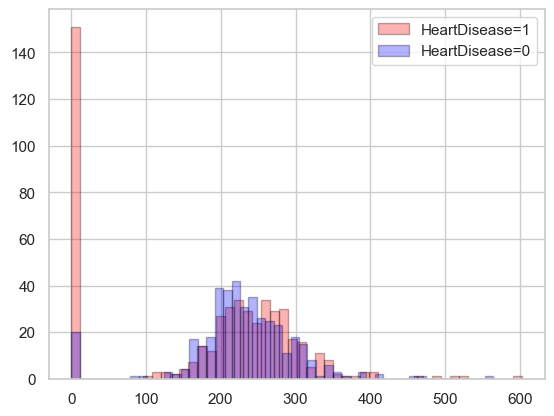

In [27]:
#Checking Cholesterol invalid zeros so we can check it's impact on  Heart Disease

heart_disease_0 = heart_copy[heart_copy['HeartDisease'] == 0]
heart_disease_1 = heart_copy[heart_copy['HeartDisease'] == 1]

plt.hist(heart_disease_1['Cholesterol'], color='red', label='HeartDisease=1',bins=50,alpha=0.3,edgecolor='black')
plt.hist(heart_disease_0['Cholesterol'], color='blue', label='HeartDisease=0', bins=50,alpha=0.3,edgecolor='black')
plt.legend()
plt.show()

### Observations
- A significant number of **invalid zero values** for cholesterol are observed in individuals with **heart disease**, compared to those without.
- This discrepancy suggests that many of these **zero values** might actually represent **high cholesterol levels** rather than truly missing or absent data.
- The pattern indicates a potential **data entry issue** or incorrect recording of cholesterol values for individuals at higher risk of heart disease.
- Further validation and imputation strategies may be necessary to ensure data integrity and derive accurate insights.

Encoding the dataset to impute cholesterole using knnimputer:

In [28]:

encoder = OrdinalEncoder()

features = ['Sex', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
cat_encoded = encoder.fit_transform(heart_copy[features])
cat_encoded = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(), index=heart_copy.index)  # Convert sparse matrix to dense
df_encoded = pd.concat([heart_copy.drop(columns=features), cat_encoded], axis=1)  # Ensure proper merging

In [32]:

knn_imputer = KNNImputer(n_neighbors=5)

df_encoded['Cholesterol'] = df_encoded['Cholesterol'].replace(0,np.nan)

df_encoded['Cholesterol']=knn_imputer.fit_transform(df_encoded)

heart_copy['Cholesterol']=df_encoded['Cholesterol']

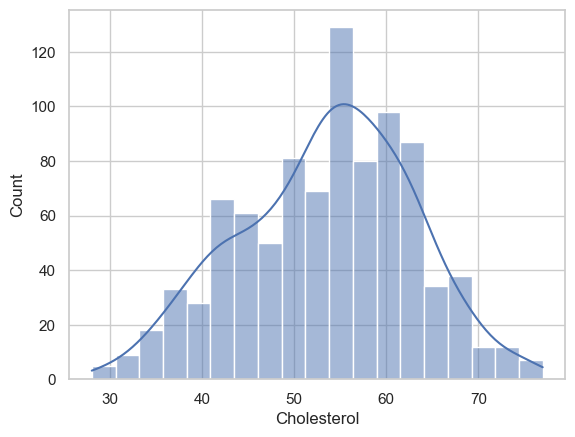

In [33]:
#Let's plot the cholesetor again and see the changes
plt.figure()
sns.histplot(heart_copy['Cholesterol'],kde=True)
plt.show()

Bivariate Analysis for numerical Data:

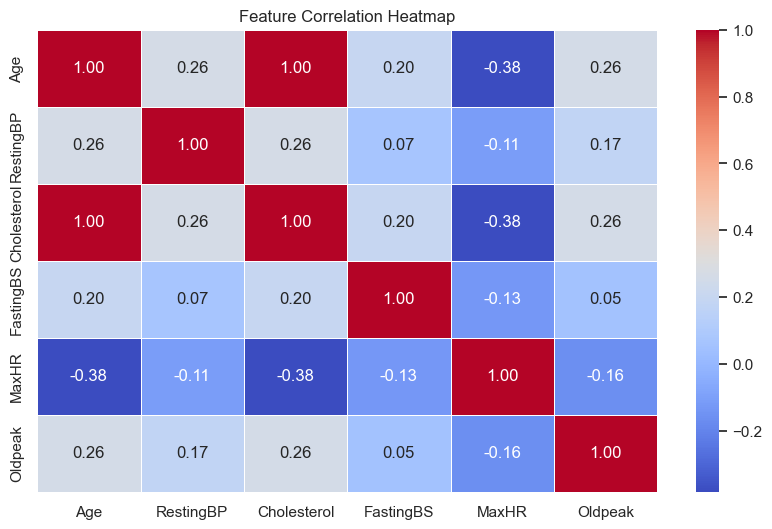

In [34]:
corr_matrix = heart_copy.select_dtypes(exclude=object).drop(columns='HeartDisease').corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

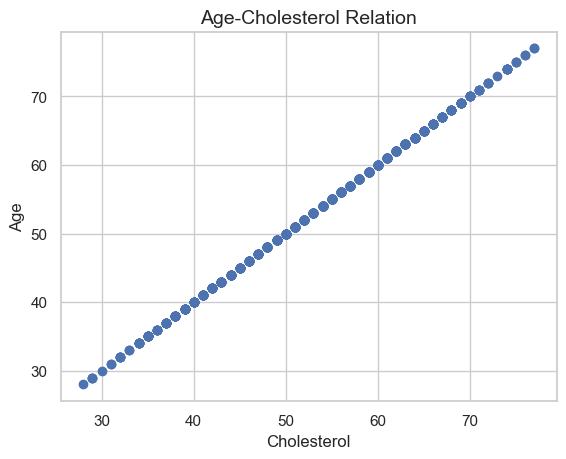

In [35]:
plt.figure()
plt.scatter(x=heart_copy['Cholesterol'],y=heart_copy['Age'])
plt.title('Age-Cholesterol Relation',fontsize=14)
plt.xlabel('Cholesterol',fontsize=12)
plt.ylabel('Age',fontsize=12)
plt.show()

- The **Cholesterol** and **Age** features exhibit a **perfect correlation (1.0)**.
- This suggests a highly linear relationship where **cholesterol values increase proportionally with age**.
- Such a strong correlation could indicate **data redundancy** or potential issues with data recording.
- Further validation is needed to ensure this correlation is **accurate** and not due to an underlying data artifact.
- If confirmed, this relationship could be **important for predictive modeling**, influencing feature selection in machine learning.

In [36]:
for i in conti_features:
    print(f"{i}:{df_encoded[i].skew()}")

Age:-0.19532159788386802
RestingBP:0.6071947160162691
Cholesterol:-0.19532159788386802
MaxHR:-0.14245852926814553
Oldpeak:1.024544634289045


- The **Oldpeak** feature exhibits **moderate skewness**, which may affect the performance of machine learning models.
- Skewed data can introduce bias, impact model assumptions, and reduce predictive accuracy.

## Feature Importance and Selection

In [37]:
df_encoded['HR_ExerciseImpact'] = df_encoded['MaxHR'] / (df_encoded['Oldpeak'] + 5)

In [38]:
cat_encoded_features=[i for i in df_encoded.columns if df_encoded[i].nunique()<10]

Chi2 Test:

In [39]:
X = df_encoded[cat_encoded_features]  
y = df_encoded['HeartDisease']  

chi2_selector = SelectKBest(score_func=chi2, k='all')  
X_selected = chi2_selector.fit_transform(X, y)

# Retrieve feature importance scores
scores = chi2_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': scores})
feature_scores = feature_scores.sort_values(by='Chi2 Score', ascending=False)

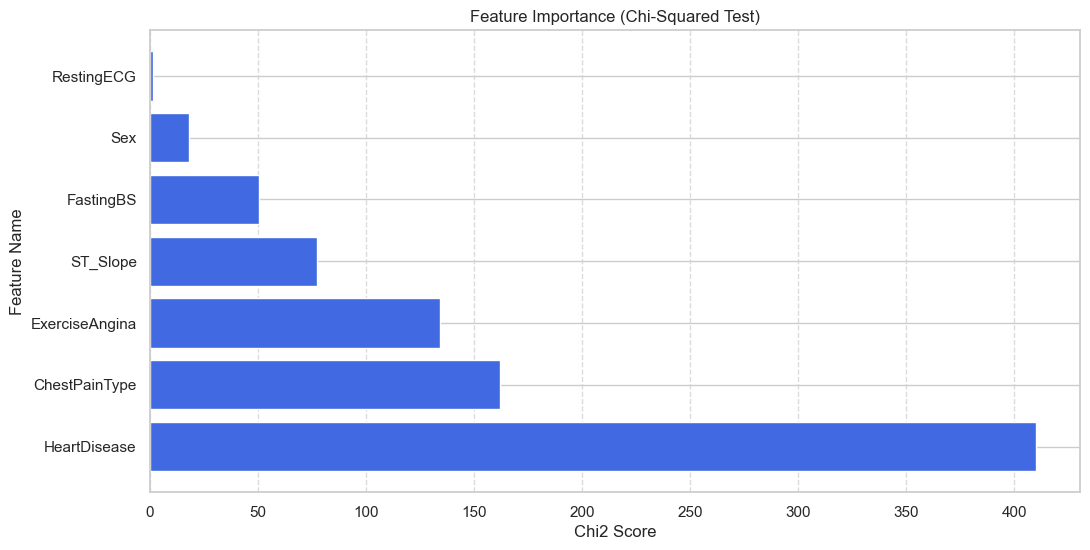

In [40]:
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['Chi2 Score'], color='royalblue')
plt.xlabel('Chi2 Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (Chi-Squared Test)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Chi2 Test Rsult: Feature Importance
- The **Chi-Square test** results indicate that **RestingECG** and **Sex** have the **least feature importance** in relation to heart disease prediction.
- This suggests that these features **may not contribute significantly** to distinguishing between individuals with and without heart disease.
- While **RestingECG** is an important diagnostic tool, its statistical impact in this dataset appears minimal.
- The **Sex** feature also shows limited influence, implying that heart disease risk factors might be **more closely tied to other clinical or lifestyle attributes**.
- Further analysis could involve **feature selection techniques** to determine if these features should be excluded from predictive modeling.

In [41]:
num_encoded_features=[i for i in df_encoded.columns if df_encoded[i].nunique()>10]

Anova Test:

In [42]:

X = df_encoded[num_encoded_features]  
y = heart_copy['HeartDisease']  

anova_selector = SelectKBest(score_func=f_classif, k='all')  # Select all for evaluation
X_selected = anova_selector.fit_transform(X, y)

scores = anova_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'ANOVA Score': scores})


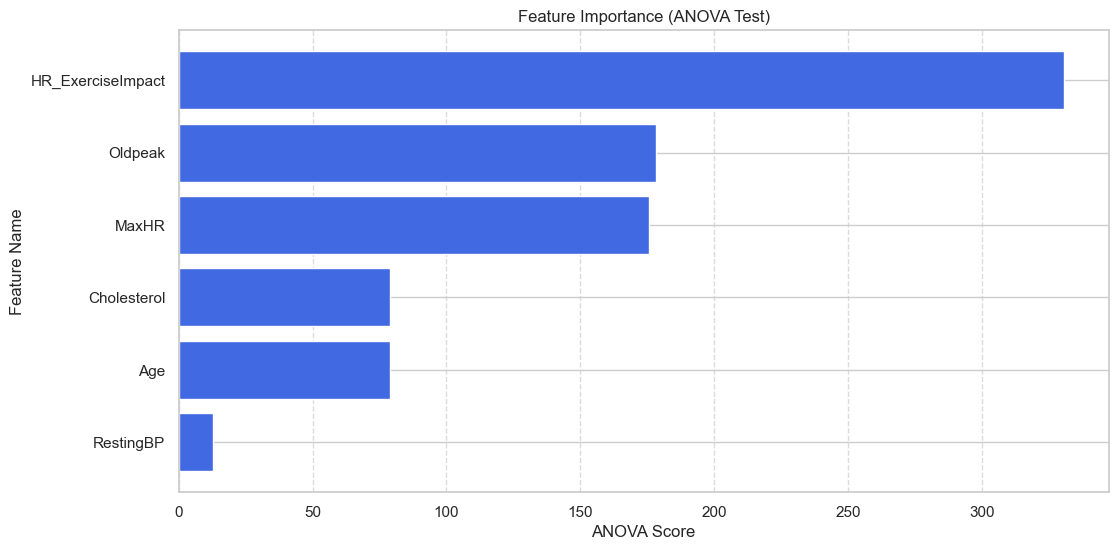

In [43]:
feature_scores=feature_scores.sort_values(by='ANOVA Score',ascending=True)
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['ANOVA Score'], color='royalblue')
plt.xlabel('ANOVA Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (ANOVA Test)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### ANOVA Test Results: Feature Importance Analysis

### Observations
- The **ANOVA test** indicates that **RestingBP (Resting Blood Pressure)** has the **least importance** in this dataset.
- In contrast, **Oldpeak** and **MaxHR (Maximum Heart Rate)** exhibit a **strong relationship**, suggesting their significant influence on heart disease prediction.
- The high correlation between **Oldpeak and MaxHR** may indicate that exercise-induced changes in heart rate and ST depression play a crucial role in cardiovascular health.

Permutation feature Importance test:

In [45]:
X=df_encoded.drop(columns=['HeartDisease'])
y=df_encoded['HeartDisease']
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rnd_clf.feature_importances_})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


perm_importance = permutation_importance(rnd_clf, X, y, scoring='f1')

perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

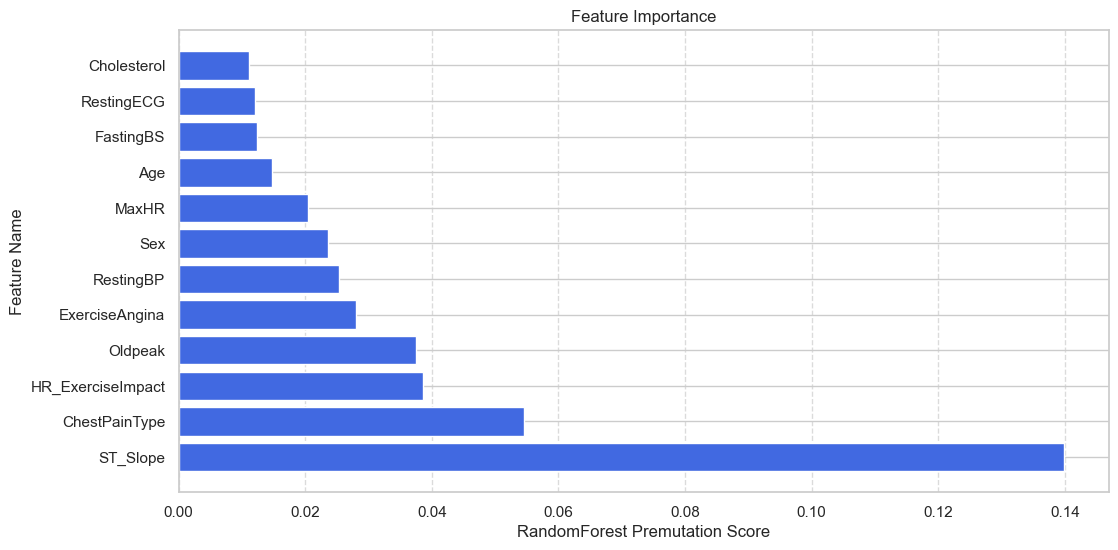

In [46]:
plt.figure(figsize=(12, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='royalblue')
plt.xlabel('RandomForest Premutation Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

- After the test we are sure witch our new feature is usefull, so we add it do the main dataset.

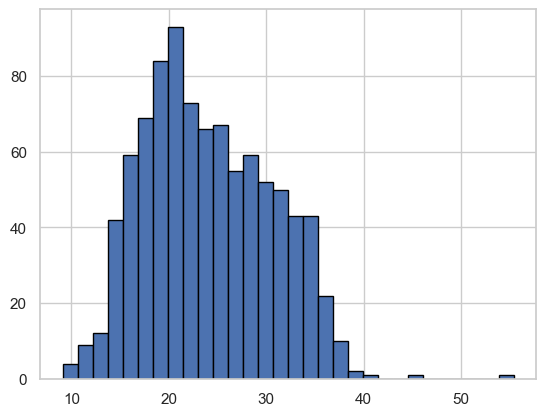

In [47]:
heart_copy['HR_ExerciseImpact'] = heart_copy['MaxHR'] / (heart_copy['Oldpeak'] + 5)

plt.figure()
plt.hist(heart_copy['HR_ExerciseImpact'],bins=30,edgecolor='black')
plt.show()

### Feature Selection:
- Acording to test results it's better to drop **RestingECG** and **FastingBS**.

In [ ]:
# base on the tests we have done we can drop the RestingECG and  FastingBS.
heart_copy.drop(columns=['RestingECG','FastingBS'],inplace=True)